<a href="https://colab.research.google.com/github/reshalfahsi/medical-image-latent-space-visualization/blob/master/Medical_Image_Latent_Space_Visualization_Using_VQ_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medical Image Latent Space Visualization Using VQ-VAE**

## **Important Libraries**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 387.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 368.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 314.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
try:
    import lightning as L
except:
    import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics.image import (
    PeakSignalNoiseRatio,
    StructuralSimilarityIndexMeasure
)
from torchmetrics.regression import MeanAbsoluteError
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision.models import resnet18
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, Resize
from torchvision.datasets.utils import download_url

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from medmnist.dataset import MedMNIST
from medmnist.info import INFO, HOMEPAGE, DEFAULT_ROOT

from PIL import Image

from tqdm import tqdm_notebook

import os
import cv2
import random
import math
import warnings
import time

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [ ]:
MAX_EPOCH = 32
BATCH_SIZE = 16
LR = 2e-2
INPUT_DIM = 3
HIDDEN_DIM = 2
N_EMBEDDING = 512
OUTPUT_DIM = 3
IMAGE_SIZE = 64

DATASET = [
    "dermamnist",
    "pneumoniamnist",
    "retinamnist",
    "breastmnist",
    "bloodmnist",
]

## **Dataset**

### **Utils**

In [ ]:
image_transform = Compose(
    [
        Resize(IMAGE_SIZE),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

In [ ]:
class BiomedicalDataset(data.Dataset):
    flags = DATASET

    def __init__(
        self,
        splits=["train", "val", "test"],
        transform=image_transform,
        download=True,
        root=DEFAULT_ROOT,
    ):
        """dataset
        :param split: 'train', 'val' or 'test', select subset
        :param transform: data transformation
        :param target_transform: target transformation

        """

        self.train_imgs = list()
        self.val_imgs = list()
        self.test_imgs = dict()

        for flag in self.flags:
            self.flag = flag
            for split in splits:
                self.info = INFO[self.flag]

                if root is not None and os.path.exists(root):
                    self.root = root
                else:
                    raise RuntimeError(
                        "Failed to setup the default `root` directory. "
                        + "Please specify and create the `root` directory manually."
                    )

                if download:
                    self.download()

                if not os.path.exists(
                    os.path.join(self.root, "{}.npz".format(self.flag))
                ):
                    raise RuntimeError(
                        "Dataset not found. "
                        + " You can set `download=True` to download it"
                    )

                npz_file = np.load(os.path.join(self.root, "{}.npz".format(self.flag)))

                self.split = split
                self.transform = transform

                if self.split == "train":
                    self.train_imgs += npz_file["train_images"].tolist()
                elif self.split == "val":
                    self.val_imgs += npz_file["val_images"].tolist()
                elif self.split == "test":
                    self.test_imgs[flag] = (
                        npz_file["train_images"].tolist()
                        + npz_file["test_images"].tolist()
                        + npz_file["val_images"].tolist()
                    )
                else:
                    raise ValueError

        del self.flag, self.root, self.info, self.split

    @property
    def __train__(self):
        self.split = "train"
        return self

    @property
    def __val__(self):
        self.split = "val"
        return self

    def __test__(self, flag):
        self.split = "test"
        self.flag = flag
        return self

    def __getitem__(self, index):
        """
        return: (without transform/target_transofrm)
            img: PIL.Image
        """
        try:
            if self.split == "train":
                img = np.array(self.train_imgs[index])
            elif self.split == "val":
                img = np.array(self.val_imgs[index])
            elif self.split == "test":
                img = np.array(self.test_imgs[self.flag][index])
        except:
            raise TypeError("Error while handling dataset's split type")

        img = Image.fromarray(img.astype(np.uint8))

        if len(img.getbands()) < 3:
            img = img.convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        try:
            if self.split == "train":
                return len(self.train_imgs)
            elif self.split == "val":
                return len(self.val_imgs)
            elif self.split == "test":
                return len(self.test_imgs[self.flag])
        except:
            TypeError("Error while handling dataset's split type")


    def __repr__(self):
        """Adapted from torchvision.ss"""
        _repr_indent = 4
        head = f"{self.__class__.__name__}"
        body = [f"Number of datapoints: {self.__len__()}"]
        body.append(f"Number of channels: 3")

        lines = [head] + [" " * _repr_indent + line for line in body]
        return "\n".join(lines)

    def download(self):
        try:
            download_url(
                url=self.info["url"],
                root=self.root,
                filename="{}.npz".format(self.flag),
                md5=self.info["MD5"],
            )
        except:
            raise RuntimeError(
                "Something went wrong when downloading! "
                + "Go to the homepage to download manually. "
                + HOMEPAGE
            )

In [ ]:
biomedical_dataset = BiomedicalDataset()

100%|██████████| 19725078/19725078 [00:02<00:00, 9523077.47it/s] 


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


100%|██████████| 4170669/4170669 [00:01<00:00, 3425794.78it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


100%|██████████| 3291041/3291041 [00:01<00:00, 2583288.98it/s]


Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz


100%|██████████| 559580/559580 [00:00<00:00, 722094.60it/s]


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


100%|██████████| 35461855/35461855 [00:02<00:00, 13522478.73it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


## **Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self, complete=False):
        self.reset()
        self.complete = complete

    def reset(self):
        self.scores = []

    def update(self, val):
        self.scores.append(val)

    @property
    def score(self):
        score = [s.numpy() for s in self.scores]
        return score

    def show(self):
        scores = torch.stack(self.scores)

        if self.complete:
            mean = torch.mean(scores)
            std = torch.std(scores)
            return mean, std
        else:
            return torch.mean(scores)

In [ ]:
class DataPoint:
    x = 0.
    y = 0.
    color = 'red'
    marker = 'o'
    label = None

### **Encoder**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()

        self.backbone = torch.hub.load(
            'pytorch/vision:v0.10.0', 'resnet18', pretrained=True
        )

        del self.backbone.layer3, self.backbone.layer4
        del self.backbone.avgpool, self.backbone.fc

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, hidden_dim, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim),
        )

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)

        x = self.layer3(x)

        return x

### **Vector Quantizer Embedding Exponential Moving Average**

In [ ]:
class VQEmbeddingEMA(nn.Module):
    def __init__(
        self,
        n_embeddings,
        embedding_dim,
        commitment_cost=0.25,
        decay=0.999,
        epsilon=1e-5,
    ):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(
            torch.sum(self.embedding**2, dim=1)
            + torch.sum(x_flat**2, dim=1, keepdim=True),
            x_flat,
            self.embedding.t(),
            alpha=-2.0,
            beta=1.0,
        )

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)

        return quantized

    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)

        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(
            torch.sum(self.embedding**2, dim=1)
            + torch.sum(x_flat**2, dim=1, keepdim=True),
            x_flat,
            self.embedding.t(),
            alpha=-2.0,
            beta=1.0,
        )

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)

        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(
                encodings, dim=0
            )
            n = torch.sum(self.ema_count)
            self.ema_count = (
                (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n
            )

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

### **Decoder**

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self, input_dim, output_dim,
    ):
        super(Decoder, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convskip1 = nn.Sequential(
            nn.Conv2d(input_dim, 64, 1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convtranspose1 = nn.ConvTranspose2d(
            64, 64, 2, 2
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convskip2 = nn.Sequential(
            nn.Conv2d(64, 64, 1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convtranspose2 = nn.ConvTranspose2d(
            64, 64, 2, 2
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convskip3 = nn.Sequential(
            nn.Conv2d(64, 64, 1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convtranspose3 = nn.ConvTranspose2d(
            64, 64, 2, 2
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
        )
        self.convskip4 = nn.Sequential(
            nn.Conv2d(64, 32, 1, bias=False),
            nn.BatchNorm2d(32),
        )
        self.convtranspose4 = nn.ConvTranspose2d(
            32, 32, 2, 2
        )

        self.final_conv = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x) + self.convskip1(x)
        x = self.convtranspose1(x)

        x = self.conv2(x) + self.convskip2(x)
        x = self.convtranspose2(x)

        x = self.conv3(x) + self.convskip3(x)
        x = self.convtranspose3(x)

        x = self.conv4(x) + self.convskip4(x)
        x = self.convtranspose4(x)

        return self.final_conv(x)

### **VQ-VAE (Vector-Quantized Variational AutoEncoder)**

In [ ]:
class VQVAE(L.LightningModule):
    def __init__(self, encoder, codebook, decoder, batch_size, lr, max_epoch):
        super().__init__()

        self.encoder = encoder
        self.codebook = codebook
        self.decoder = decoder

        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.datapoints = list()

        self.train_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.train_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.train_mae = MeanAbsoluteError()

        self.val_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.val_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.val_mae = MeanAbsoluteError()

        self.train_psnr_recorder = AvgMeter()
        self.train_ssim_recorder = AvgMeter()
        self.train_mae_recorder = AvgMeter()

        self.val_psnr_recorder = AvgMeter()
        self.val_ssim_recorder = AvgMeter()
        self.val_mae_recorder = AvgMeter()

        self.train_psnr_list = list()
        self.train_ssim_list = list()
        self.train_mae_list = list()

        self.val_psnr_list = list()
        self.val_ssim_list = list()
        self.val_mae_list = list()

        self.train_total_loss_recorder = AvgMeter()
        self.val_total_loss_recorder = AvgMeter()

        self.train_total_loss = list()
        self.val_total_loss = list()

        self.sanity_check_counter = 1

        self.automatic_optimization = False

    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        return x_hat, commitment_loss, codebook_loss, perplexity

    def latent_embedding(self, x):
        z = self.encoder(x)
        result = self.codebook.encode(z)
        return result.mean(dim=[2,3])

    def test_step(self, batch, batch_nb):
        x = batch
        latent = self.latent_embedding(x).squeeze(0).data.cpu().numpy()
        datapoint = DataPoint()
        datapoint.x = latent[0]
        datapoint.y = latent[1]
        datapoint.label = self.dataset_name


        if self.dataset_name == "dermamnist":
            datapoint.color = "blue"
            datapoint.marker = "o"
        elif self.dataset_name == "pneumoniamnist":
            datapoint.color = "purple"
            datapoint.marker = "s"
        elif self.dataset_name == "retinamnist":
            datapoint.color = "green"
            datapoint.marker = "s"
        elif self.dataset_name == "breastmnist":
            datapoint.color = "black"
            datapoint.marker = "P"
        elif self.dataset_name == "bloodmnist":
            datapoint.color = "gold"
            datapoint.marker = "P"
        else:
            raise TypeError(f"Unidentified dataset_name: {self.dataset_name}")

        self.datapoints.append(datapoint)

    def training_step(self, batch, batch_nb):

        ########################################################################

        x = batch
        x_hat, commitment_loss, codebook_loss, perplexity = self(x)
        recon_loss = F.mse_loss(x_hat, x)
        total_loss = recon_loss + commitment_loss + codebook_loss

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(total_loss)
        opt.step()

        ########################################################################

        self.log(
            "train_total_loss",
            total_loss,
            prog_bar=True,
        )
        self.train_total_loss_recorder.update(total_loss.data)

        self.train_psnr.update(x_hat, x)
        psnr = self.train_psnr.compute().data.cpu()

        self.train_ssim.update(x_hat, x)
        ssim = self.train_ssim.compute().data.cpu()

        self.train_mae.update(x_hat, x)
        mae = self.train_mae.compute().data.cpu()

        self.log("train_psnr", psnr, prog_bar=True)
        self.log("train_ssim", ssim, prog_bar=True)
        self.log("train_mae", mae, prog_bar=True)

        self.train_psnr_recorder.update(psnr)
        self.train_ssim_recorder.update(ssim)
        self.train_mae_recorder.update(mae)

    def on_train_epoch_end(self):
        mean = self.train_total_loss_recorder.show()
        self.train_total_loss.append(mean.data.cpu().numpy())
        self.train_total_loss_recorder = AvgMeter()

        mean = self.train_mae_recorder.show()
        self.train_mae_list.append(mean.data.cpu().numpy())
        self.train_mae_recorder = AvgMeter()

        mean = self.train_psnr_recorder.show()
        self.train_psnr_list.append(mean.data.cpu().numpy())
        self.train_psnr_recorder = AvgMeter()

        mean = self.train_ssim_recorder.show()
        self.train_ssim_list.append(mean.data.cpu().numpy())
        self.train_ssim_recorder = AvgMeter()

        self._plot_evaluation_metrics()

    def validation_step(self, batch, batch_nb):
        ########################################################################

        x = batch
        x_hat, commitment_loss, codebook_loss, perplexity = self(x)
        recon_loss = F.mse_loss(x_hat, x)
        total_loss = recon_loss + commitment_loss + codebook_loss

        ########################################################################

        self.log(
            "val_total_loss",
            total_loss,
            prog_bar=True,
        )
        self.val_total_loss_recorder.update(total_loss.data)

        self.val_psnr.update(x_hat, x)
        psnr = self.val_psnr.compute().data.cpu()

        self.val_ssim.update(x_hat, x)
        ssim = self.val_ssim.compute().data.cpu()

        self.val_mae.update(x_hat, x)
        mae = self.val_mae.compute().data.cpu()

        self.log("val_psnr", psnr, prog_bar=True)
        self.log("val_ssim", ssim, prog_bar=True)
        self.log("val_mae", mae, prog_bar=True)

        self.val_psnr_recorder.update(psnr)
        self.val_ssim_recorder.update(ssim)
        self.val_mae_recorder.update(mae)

    def on_validation_epoch_end(self):
        mean = self.val_total_loss_recorder.show()
        self.val_total_loss.append(mean.data.cpu().numpy())
        self.val_total_loss_recorder = AvgMeter()

        mean = self.val_mae_recorder.show()
        self.val_mae_list.append(mean.data.cpu().numpy())
        self.val_mae_recorder = AvgMeter()

        mean = self.val_psnr_recorder.show()
        self.val_psnr_list.append(mean.data.cpu().numpy())
        self.val_psnr_recorder = AvgMeter()

        mean = self.val_ssim_recorder.show()
        if self.sanity_check_counter == 0:
            sch = self.lr_schedulers()
            sch.step(mean)
            print(
                f"[{MODEL_NAME}] Learning Rate: {self.optimizers().param_groups[0]['lr']}"
            )
        else:
            self.sanity_check_counter -= 1
        self.val_ssim_list.append(mean.data.cpu().numpy())
        self.val_ssim_recorder = AvgMeter()

    def set_test_metadata(self, dataset_name):
        self.dataset_name = dataset_name

    def _plot_evaluation_metrics(self):
        # Total Loss
        loss_img_file = (
            f"{EXPERIMENT_DIR}/{MODEL_NAME}_total_loss_plot.png"
        )
        plt.plot(self.train_total_loss, color="r", label="train")
        plt.plot(self.val_total_loss[1:], color="b", label="validation")
        plt.title("Total Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()

        # PSNR
        psnr_img_file = f"{EXPERIMENT_DIR}/{MODEL_NAME}_psnr_plot.png"
        plt.plot(self.train_psnr_list, color="r", label="train")
        plt.plot(self.val_psnr_list[1:], color="b", label="validation")
        plt.title("PSNR Curves")
        plt.xlabel("Epoch")
        plt.ylabel("PSNR")
        plt.legend()
        plt.grid()
        plt.savefig(psnr_img_file)
        plt.clf()

        # SSIM
        ssim_img_file = f"{EXPERIMENT_DIR}/{MODEL_NAME}_ssim_plot.png"
        plt.plot(self.train_ssim_list, color="r", label="train")
        plt.plot(self.val_ssim_list[1:], color="b", label="validation")
        plt.title("SSIM Curves")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.legend()
        plt.grid()
        plt.savefig(ssim_img_file)
        plt.clf()

        # MAE
        mae_img_file = f"{EXPERIMENT_DIR}/{MODEL_NAME}_mae_plot.png"
        plt.plot(self.train_mae_list, color="r", label="train")
        plt.plot(self.val_mae_list[1:], color="b", label="validation")
        plt.title("MAE Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid()
        plt.savefig(mae_img_file)
        plt.clf()

    def train_dataloader(self):
        return data.DataLoader(
            dataset=biomedical_dataset.__train__,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=biomedical_dataset.__val__,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            weight_decay=1e-3,
            momentum=0.9,
            nesterov=True,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="max",
                factor=0.1,
                patience=2,
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

In [ ]:
MODEL = VQVAE
MODEL_NAME = MODEL.__name__

In [ ]:
EXPERIMENT_DIR = "/content/"
BEST_MODEL_PATH = os.path.join(EXPERIMENT_DIR, f"{MODEL_NAME}_best.ckpt")

## **Training**

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1871857900


In [ ]:
model, trainer, checkpoint, early_stopping = None, None, None, None


def _train_loop():
    seed_everything(SEED, workers=True)

    ENCODER = Encoder(hidden_dim=HIDDEN_DIM)
    CODEBOOK = VQEmbeddingEMA(n_embeddings=N_EMBEDDING, embedding_dim=HIDDEN_DIM)
    DECODER = Decoder(input_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

    model = MODEL(ENCODER, CODEBOOK, DECODER, BATCH_SIZE, LR, MAX_EPOCH)

    checkpoint = ModelCheckpoint(
        monitor='val_ssim',
        dirpath=EXPERIMENT_DIR,
        mode='max',
        filename=f"{MODEL_NAME}_best",
    )
    print(MODEL_NAME)
    early_stopping = EarlyStopping(
        monitor="val_ssim", min_delta=0.00, patience=8, verbose=False, mode="max"
    )

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=[checkpoint, early_stopping],
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

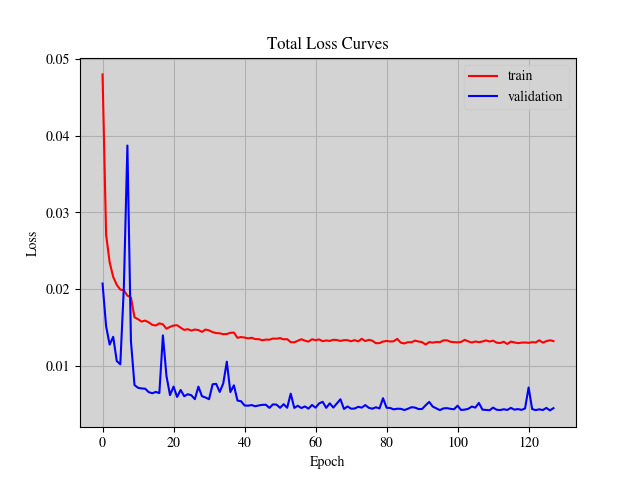

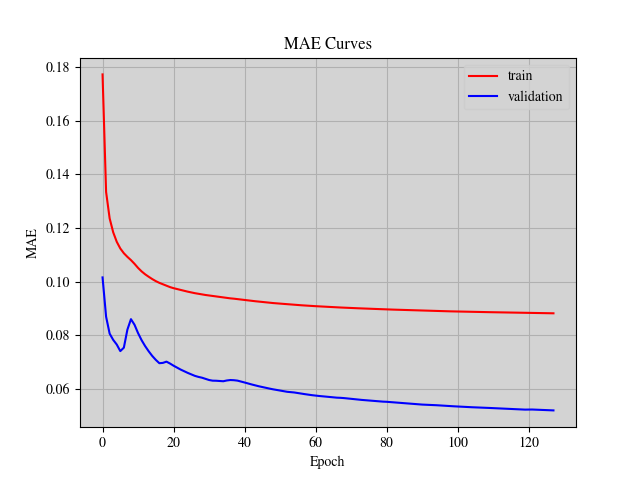

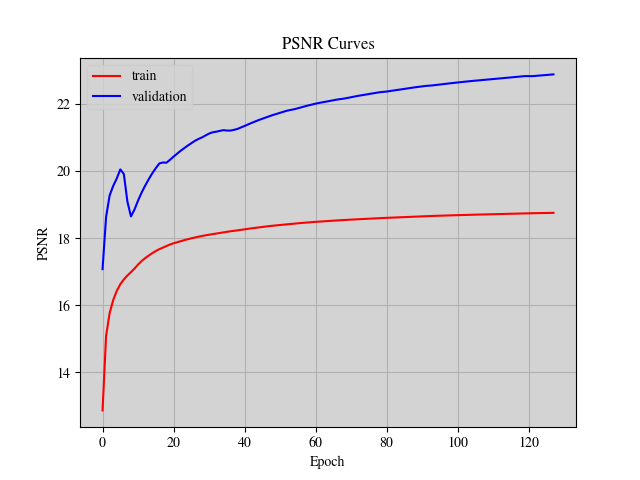

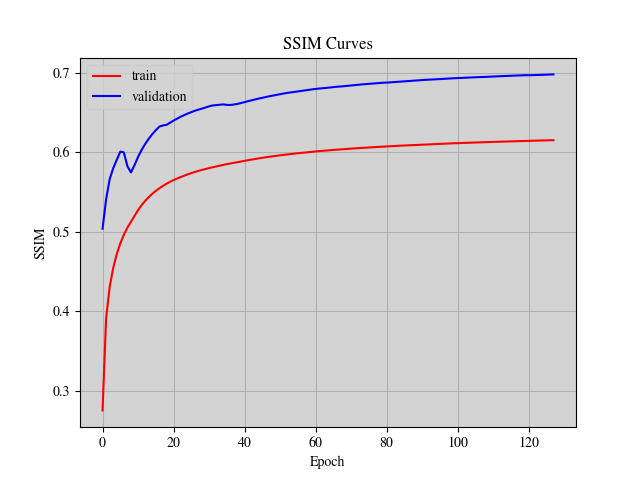

In [ ]:
img = cv2.imread(f"{EXPERIMENT_DIR}/{MODEL_NAME}_total_loss_plot.png")
cv2_imshow(img)
img = cv2.imread(f"{EXPERIMENT_DIR}/{MODEL_NAME}_mae_plot.png")
cv2_imshow(img)
img = cv2.imread(f"{EXPERIMENT_DIR}/{MODEL_NAME}_psnr_plot.png")
cv2_imshow(img)
img = cv2.imread(f"{EXPERIMENT_DIR}/{MODEL_NAME}_ssim_plot.png")
cv2_imshow(img)
del img

## **Inference**

### **Utils**

In [ ]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, linewidth=3, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### **Gather the Vector Quantized Latent Representation**

In [ ]:
trainer = Trainer(accelerator='auto', logger=False)

ENCODER = Encoder(hidden_dim=HIDDEN_DIM)
CODEBOOK = VQEmbeddingEMA(n_embeddings=N_EMBEDDING, embedding_dim=HIDDEN_DIM)
DECODER = Decoder(input_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

model = MODEL(ENCODER, CODEBOOK, DECODER, BATCH_SIZE, LR, MAX_EPOCH)

for dataset_name in DATASET:
    print(f"======================{dataset_name}==============================")
    model.set_test_metadata(dataset_name=dataset_name)
    trainer.test(
        model=model,
        ckpt_path=BEST_MODEL_PATH,
        dataloaders=data.DataLoader(
                dataset=biomedical_dataset.__test__(dataset_name),
                batch_size=1,
                shuffle=False,
        ),
    )

### **Visualize the Latent Space**

  0%|          | 0/35343 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

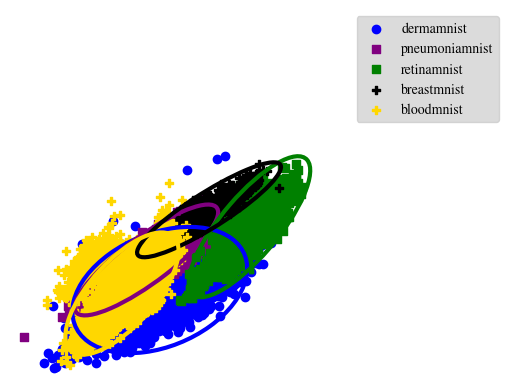

In [ ]:
plt.clf()
fig, ax = plt.subplots()
has_been_called = set()
points = {dataset: list() for dataset in DATASET}

for datapoint in tqdm_notebook(model.datapoints):
    x = datapoint.x
    y = datapoint.y
    label = datapoint.label
    points[label].append([x, y])
    ax.scatter(
        x,
        y,
        c=datapoint.color,
        marker=datapoint.marker,
        label=label if label not in has_been_called else "",
    )
    has_been_called.add(label)

for dataset_name, dataset in points.items():
    if dataset_name == "dermamnist":
        color = "blue"
    elif dataset_name == "pneumoniamnist":
        color = "purple"
    elif dataset_name == "retinamnist":
        color = "green"
    elif dataset_name == "breastmnist":
        color = "black"
    elif dataset_name == "bloodmnist":
        color = "gold"
    dataset = np.array(dataset)
    confidence_ellipse(dataset[:, 0], dataset[:, 1], ax, edgecolor=color)

min_, max_ = plt.xlim()
ax.set_xlim([min_, 2.25 * max_])
min_, max_ = plt.ylim()
ax.set_ylim([min_, 2.25 * max_])
plt.axis('off')
plt.legend(loc="upper right")
plt.savefig(f"{EXPERIMENT_DIR}/latent_space.pdf")